(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random
import Distributions

# Import basic math
import LinearAlgebra

# Functionality for constructing arrays with identical elements efficiently.
import FillArrays

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of the mean fitness

In this notebook, we perform Bayesian inference on the mean fitness of a yeast
population based on the frequency change of barcoded neutral strains.

## The fitness model

Empirically, we have seen that the barcode trajectories follow an exponential
function of the form
$$
f_{t+1}^{(m)} = f_{t}^{(m)} \mathrm{e}^{(s^{(m)} - \bar{s}_t)T},
\tag{1}
$$
where $f_{t}^{(m)}$ is the frequency of barcode $m$ at time $t$, $s^{(m)}$ is
the relative fitness with respect to the ancestral strain, $\bar{s}_t$ is the 
mean fitness of the culture at time $t$, and $T$ is the time pass between time 
$t$ and $t+1$. It is important to notice that the frequencies $f_{t}^{(m)}$ 
are not the allele frequencies in the population (most of the culture is not
sequenced since it is not barcoded), but rather the inferred frequencies from
the total number of reads.

Our ultimate objective is to infer the relative fitness $s^{(m)}$ for each of
the mutants. But, to do so, we must first infer the population mean fitness
$\bar{s}_t$. For this, we use a set of barcoded strains that have the same
fitness as the ancestral strain--which by definition has $s^{(m)} = 0$. Here, we
will use these barcoded strains to determine the value of the population mean
fitness in a principled way using Bayesian inference.

## Non-Bayesian data normalization

Before implementing the full Bayesian model, let's explore the data. We will
take a look at what the frequency changes look like.

The first step is to load the data. The dataframe we will use was previously set
into a tidy format for easier manipulation.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral,count_sum,freq
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String31,Bool,Int64,Float64
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false,543947,9.7436e-5
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false,543947,0.00223
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false,543947,3.1253e-5
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false,543947,3.49299e-5
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false,543947,4.22835e-5


### Frequency trajectories

To begin our exploration, let's plot some of the barcode trajectories for a
particular experiment. An experiment is defined by a batch number (`batch`),
environment hub (`hub`), perturbation (`perturbation`) and replicate number
`rep`.

For this plot, we will display barcode trajectories over time. The neutral
lineages (with mean fitness $s^{(m)} = 0$) will be highlighted with dark blue
lines.

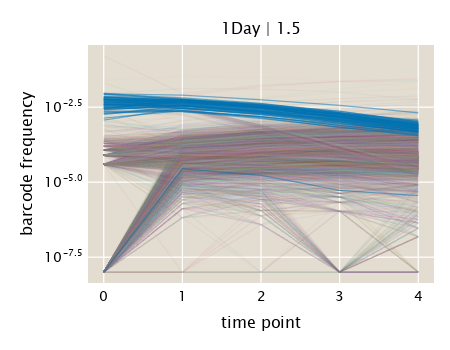

In [3]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
# Define evironment hub
hub = "1Day"
# Define perturbation
perturbation = "1.5"
# Define repeat number
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(hub) | $(perturbation)"
)

# Define color palette for mutant barcodes
colors = ColorSchemes.glasbey_hv_n256

# Group data by barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.freq .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# Group neutral barcodes by barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.freq .+ 1E-8,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

The values shown in this plot are the naive frequencies point estimates computed
by simply normalizing the barcode counts by the total number of counts per time
point. Something strange happened between time point `T0` and `T1`, where many
barcodes drastically increased in frequency. We wil deal with these anomalies
later. Furthermore, there are barcodes that go extinct.

### Log frequency change trajectories

Note that our fitness model (Eq. 1) can be rewritten as
$$
\frac{1}{T} 
\log \left(\frac{f_{t+1}^{(m)}}{f_{t}^{(m)}}\right) = s^{(m)} - \bar{s}_t.
\tag{2}
$$
Written this way, we can see that the quantities that will be used to infer both
the mutant fitness $s^{(m)}$ and the mean fitness $\bar{s}_t$ is the log 
frequency ratio between two contiguous time points. Specifically, for the 
neutral lineages⸺indexed with letter $n$⸺we have the log frequency ratio defined
as
$$
\frac{1}{T} 
\log \left(\frac{f_{t+1}^{(n)}}{f_{t}^{(n)}}\right) =  -\bar{s}_t.
\tag{3}
$$

Let's plot this log frequency ration for all pairs of time points. Again,
neutral barcodes will be highlighted with darker blue.

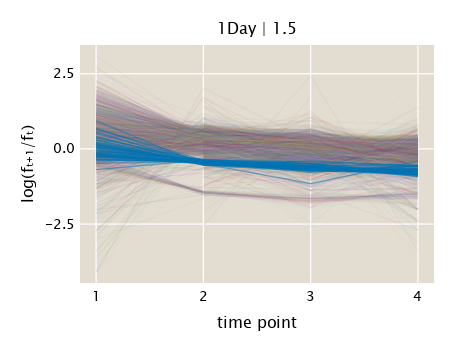

In [5]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

From this plot, we can see that since all neutrals lie below zero, the mean
fitness of the culture must be increasing, since, as shown above, for the
mutants we have
$$
\bar{s}_{t} = - \frac{1}{T} \log \left(\frac{f^{(n)}_{t+1}}{f^{(n)}_t} \right).
\tag{4}
$$
Therefore, if the log ratio of the neutrals is negative, the mean fitness
increased from point $t$ to $t+1$.

### Naive normalization of data by mean fitness

Eq. 4 shows that we can infer the value of the population mean fitness
$\bar{s}_t$ given the values of the log frequency ratio of the neural lineages.
Let's compute the naive point estimate of this value by computing
$$
\left\langle
- \log \left(\frac{f^{(n)}_{t+1}}{f^{(n)}_t} \right)
\right\rangle = \frac{1}{N} \sum_{n = 1}^N
- \log \left(\frac{f^{(n)}_{t+1}}{f^{(n)}_t} \right),
\tag{5}
$$
where $N$ is the total number of neutral linages. Later on, we will account for 
the uncertainty on this quantity in the context of a Bayesian probabilistic 
model. But for now, we simply want to subtract this quantity from all log 
frequency ratios. This will pull the neutral lineages log frequency ratios to
zero and the mutant log frequency ratios to the value of their relative fitness.

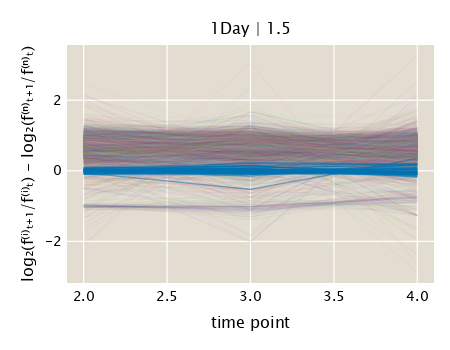

In [5]:
Random.seed!(42)

# Compute the mean population fitness s̄ₜ for all timepoints
data_st = DF.combine(
    DF.groupby(data_log[data_log.neutral, :], :time), :logf => DF.mean
)

# Locate index to extract the corresponding mean population fitness
idx_st = [findfirst(x .== data_st.time) for x in data_log.time]

# Add normalized column to dataframe
DF.insertcols!(
    data_log, :logf_norm => data_log.logf .- data_st[idx_st, :logf_mean]
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log₂(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ) - log₂(f⁽ⁿ⁾ₜ₊₁/f⁽ⁿ⁾ₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

We can see that, as expected, this normalization pulls the neutral lineages to
have a mean of zero, as expected. This subtracted quantity as defined in Eq. 5
is the parameter we will infer via Bayesian frequency.

# Naive Bayesian  model

The full inference of the population mean fitness has two sources of
uncertainty:
1. The value of the frequency inferred from raw barcode counts.
2. Variability in the log frequency ratio between different neutral lineages.

At this stage, we will ignore the first source of uncertainty, and focus only on
the lineage-to-lineage variability. We being by rewriting Eq. 1 as 
$$
\frac{f_{t+1}^{(n)}}{f_{t}^{(n)}} = \mathrm{e}^{-\bar{s}_t T},
\tag{6}
$$
where we can see that the ratio of frequencies depends exponentially on the mean
fitness we are trying to infer. Let us define 
$$
\gamma_t^{(n)} \equiv  \frac{f_{t+1}^{(n)}}{f_{t}^{(n)}}.
\tag{7}
$$
At this point, we assume our dataset consists of perfectly measured frequency
ratios
$$
\underline{\gamma}_t = (\gamma_t^{(1)}, \ldots, \gamma_t^{(N)}).
\tag{8}
$$

Next, we write Bayes theorem to infer the value of the population mean fitness.
$$
\pi(\bar{s}_t \mid \underline{\gamma}_t) \propto
\pi(\underline{\gamma}_t \mid \bar{s}_t ) \pi(\bar{s}_t),
\tag{9}
$$
where $\pi(\bar{s}_t \mid \underline{\gamma}_t)$ is the posterior distribution 
we aim to compute⸺read as the probability of parameter $\bar{s}_t$ value given
the measured frequency ratios⸺the term $\pi(\underline{\gamma}_t \mid
\bar{s}_t)$ is the so-called likelihood, and $\pi(\bar{s}_t)$ is the prior
distribution for the parameter value, i.e., the information we had about the 
parameter before observing the data.

Let's define each of the terms

#### The likelihood $\pi(\underline{\gamma}_t \mid \bar{s}_t)$

The first assumption we make is that each of the neutral linages frequency
ratios are measured independently of each other. This is not entirely true since
the values of the frequencies depends on the entire set of barcode counts. But
that correlation between samples will be taken into account when inferring the
frequencies, not the frequency ratios. This independence assumption means that
we can write
$$
\pi(\underline{\gamma}_t \mid \bar{s}_t) = 
\prod_{n=1}^N \pi\left(\gamma_t^{(n)} \mid \bar{s}_t\right).
\tag{10}
$$


We postulate that the deviations of the log frequency ratio from the theoretical
prediction follow a Normal distribution. This implies that the frequency ratios
$\gamma_t^{(n)}$ deviate from the theoretical prediction according to a
log-normal distribution. This can be simply written as
$$
\gamma_t^{(n)} \mid \bar{s}_t, \sigma_t \sim 
\log\mathcal{N}(-\bar{s}_t, \sigma_t),
\tag{11}
$$
where we introduce a nuisance parameter $\sigma_t$ that defines the standard
deviation of the log normal distribution for frequency ratios at time $t$. This
is a nuisance parameter since we don't really care about its value. But it must
be included to define our likelihood function. We can always marginalize the
value out by computing
$$
\pi\left(\gamma_t^{(n)} \mid \bar{s}_t\right) = \int d\sigma_t\;
\pi\left(\gamma_t^{(n)} \mid \bar{s}_t, \sigma_t \right).
\tag{12}
$$

Given this nuisance parameter, we must update our inference to include it. Bayes
theorem is then written like
$$
\pi (\bar{s}_t, \sigma_t \mid \underline{\gamma}_t) \propto
\prod_{n=1}^N \pi\left( \gamma_t^{(n)} \mid \bar{s}_t, \sigma_t \right)
\pi(\bar{s}_t, \sigma_t).
\tag{13}
$$
Next, let us define the prior information.

#### The prior $\pi(\bar{s}_t, \sigma_t)$

For the prior on both parameters, we first assume independence between the
paramters. This means we can write
$$
\pi(\bar{s}_t, \sigma_t) = \pi(\bar{s}_t)\pi(\sigma_t).
\tag{14}
$$
For numerical stability, we will use so-called weakly informative priors. For 
the mean fitness, we know it can take both positive⸺the overall culture 
fitness increases over time⸺or neative⸺the overall culture fitness decreases 
over time⸺values. We thus define a symmetric prior centered at zero of the 
form
$$
\bar{s}_t \sim \mathcal{N}(0, \sigma_{\bar{s}_t}),
\tag{15}
$$
where $\sigma_{\bar{s}_t}$ characterizes the variance of our normal prior. We 
are free to choose any reasonable value for this  variance. Given the large 
number of neutral lineages, this prior choice should not affect our final 
inference as the likelihood will dominate the value of the posterior.

For the $\sigma_t$ parameter, being a standard deviation, we know the parameter
must be positive. Again, for numerical stability, we define the prior to be
$$
\sigma_t \sim \text{Half}-\mathcal{N}(0, \sigma_{\sigma_t}),
\tag{16}
$$
where again we are free to choose the value of $\sigma_{\sigma_t}$.

Although the model specified above is for a single value of the mean fitness
between two time points, we can easily generalize the inference for all pairs`
of time points assuming independence for all of them. In other words, to infer
all mean fitness values $\underline{\bar{s}}_t = (\bar{s}_1, \ldots,
\bar{s}_T)$, we can compute
$$
\pi(\underline{\bar{s}}_t, \underline{\sigma}_t \mid \gamma_1, \ldots, \gamma_T)
= \prod_{t=1}^T \pi (\bar{s}_t, \sigma_t \mid \underline{\gamma}_t).
\tag{17}
$$

### Define naive inference with `Turing.jl`

Having defined the statistical model, we are ready to implement the sampling of
the posterior distribution via Markov Chain Monte Carlo. For this, we will use
the native `Julia` library `Turing.jl`. Specifically, we will use the `@model`
macro to define the statistical model.

In [6]:
@doc raw"""
    `mean_fitness_neutrals(γ̲ₜ, t, σₛ, σₑ)`

`Turing.jl` model to sample out of the posterior for all population mean fitness
values s̲ₜ = (s₁, s₂,…, sₜ). The distribution is defined as
        π(s̲ₜ, σ̲ₜ | γ̲ₜ) ∝ π(γ̲ₜ | s̲ₜ, σ̲ₜ) π(s̲ₜ, σ̲ₜ).

Arguments
- `γ̲ₜ::Array{Float64}`: frequency ratios for all neutral lineages.
- `t::Array{Int64}`: List of time points where to sample posterior.
- `σₛ::Real`: Prior variance for population mean fitness values.
- `σₑ::Real`: Prior variance for log-normal likelihiood function.
"""
Turing.@model function mean_fitness_neutrals(γ̲ₜ, t, σₛ, σₑ)
    ## Prior
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0.0, σₛ), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0 .+ eps(), σₑ); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood
    for i = 1:size(γ̲ₜ, 2)
        γ̲ₜ[:, i] ~ Turing.MvLogNormal(
            -s̲ₜ, LinearAlgebra.Diagonal(σ̲ₜ .^2 .+ eps())
        )
    end # for
end # @model function

mean_fitness_neutrals

Having defined the model, let's extract an example dataset on which to test the
sampling of the posterior.

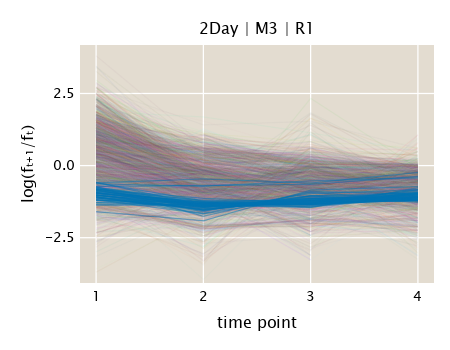

In [7]:
# Define information for data to extract
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Initialize dataframe to save the freq changes
data_gamma = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Sort data by timepoint
    DF.sort!(d, :time)
    # Compute log change
    DF.append!(
        data_gamma, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :γ => d.freq[2:end] ./ d.freq[1:end-1],
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
γ = hcat(
    [
        DF.sort(d, :time).γ
        for d in DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_gamma[.!data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

With the data at hand, we are ready to define the `Turing.jl` model and sample
out of the posterior.

In [8]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals(γ, unique(data_gamma.time), 5.0, 1.0)

# Sample
# # Suppress warning outputs
# Suppressor.@suppress begin
#     # Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    Turing.MCMCThreads(), 
    4_000, 
    4, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

       s̲ₜ[1]    0.9777    0.0285    0.0002   18846.5731   11804.9180    1.0007 ⋯
       s̲ₜ[2]    1.3668    0.0310    0.0002   16273.4032   11261.6118    1.0000 ⋯
       s̲ₜ[3]    1.1941    0.0272    0.0002   17457.1423   12030.1005    1.0003 ⋯
       s̲ₜ[4]    1.0166    0.0275    0.0002   16587.3918   11515.2901    1.0003 ⋯
       σ̲ₜ[1]    0.2110    0.0207    0.0002   18079.5775   11824.4358    1.0000 ⋯
       σ̲ₜ[2]    0.2316    0.0226    0.0002   16527.7269   10932.9864    1.0002 ⋯
       σ̲ₜ[3]    0.2002    0.0199    0.0002   16971.6073   12039.5821    0.9999 ⋯
       σ̲ₜ[4]    0.2063    0.0204    0.0002   18616.4059   11955.0552    1.0002 ⋯
                                                                1 column omitted


The values of the effective sample size (`ess`) looks really good⸺we want 
values > 400. Likewise, the values of `rhat` look around the expected range of
≈ 1.

As a matter of diagnostics, let's plot the traces and resulting densities for
each of the chains for each parameter. What we will be looking for is a general
trend where all chains seem to converge to the same range of values and no weird
patterns.

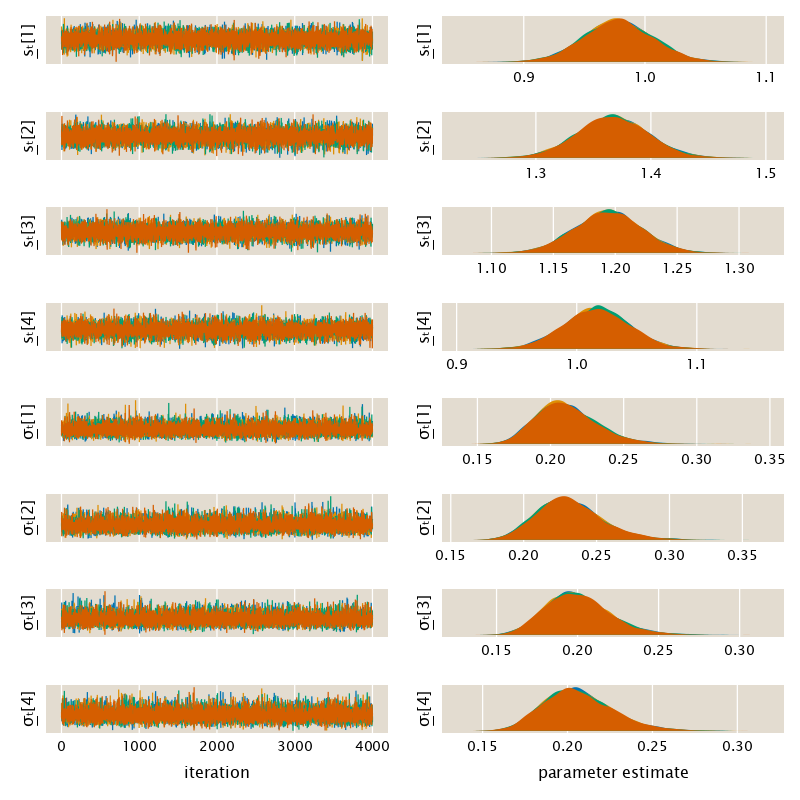

In [9]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

These seem like perfectly reasonable parameter estimates.

Let's try sampling the posterior of a different experiment.

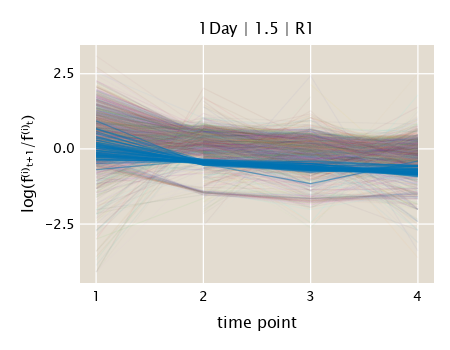

In [10]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Initialize dataframe to save the freq changes
data_gamma = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Sort data by timepoint
    DF.sort!(d, :time)
    # Compute log change
    DF.append!(
        data_gamma, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :γ => d.freq[2:end] ./ d.freq[1:end-1],
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
γ = hcat(
    [
        DF.sort(d, :time).γ
        for d in DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_gamma[.!data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

This particular dataset has an issue that halts the sampler from getting
anywhere. The problem can be easily seen by calling:

In [11]:
maximum(γ)

Inf

There are infinities in the data. This must be because for some of the samples,
there were zero counts found in the set.

The easiest (but not optimized!) way to deal with this is to ignore data points
that present this issue. As structured right now, our algorithm cannot do that
because of the "inconvenient" use of the `MvLogNormal` that we use for the
likelihood to speed up the computation. In reality, this multivariate log normal
has a diagonal covariance matrix because all the variables we are trying to fit
are independent from each other.

But, we can instead loop through each of the entries, check if they are not
infinities, and then sample a single `LogNormal` distribution. Let's write this
version of the model.

In [11]:
Turing.@model function mean_fitness_neutrals_filt(γ̲ₜ, t, σₛ, σₑ)
    ## Prior
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0.0, σₛ), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0.0, σₑ); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood
    
    for j = 1:size(γ̲ₜ, 2)
        # Define non-infinity indexes
        idx = (.!isinf.(γ̲ₜ[:, j])) .& (.!iszero.(γ̲ₜ[:, j]))
        # Sample
        γ̲ₜ[idx, j] ~ Turing.MvLogNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for
end # @model function

mean_fitness_neutrals_filt (generic function with 2 methods)

Again, with this function in hand, let's sample out of the posterior
distribution.

In [12]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals_filt(γ, unique(data_log.time), 5.0, 1.0)

# Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    Turing.MCMCThreads(), 
    4_000, 
    4, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.01435394287109375
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

       s̲ₜ[1]   -0.0044    0.0431    0.0003   18608.7911   12868.9170    1.0001 ⋯
       s̲ₜ[2]    0.4443    0.0064    0.0000   22176.0749   12484.1336    1.0003 ⋯
       s̲ₜ[3]    0.6308    0.0147    0.0001   20207.0833   12040.0490    1.0002 ⋯
       s̲ₜ[4]    0.7494    0.0154    0.0001   19896.6739   11882.9785    1.0001 ⋯
       σ̲ₜ[1]    0.3225    0.0315    0.0002   17400.3298   12635.6982    1.0001 ⋯
       σ̲ₜ[2]    0.0478    0.0047    0.0000   16738.2317   12085.2341    1.0002 ⋯
       σ̲ₜ[3]    0.1092    0.0108    0.0001   18325.7100   12367.2110    1.0008 ⋯
       σ̲ₜ[4]    0.1143    0.0112    0.0001   16951.0989   12379.4720    1.0000 ⋯
                                                                1 column omitted


The diagnostics again look okay. Let's again take a looks at the traces and 
resulting parameter densities.

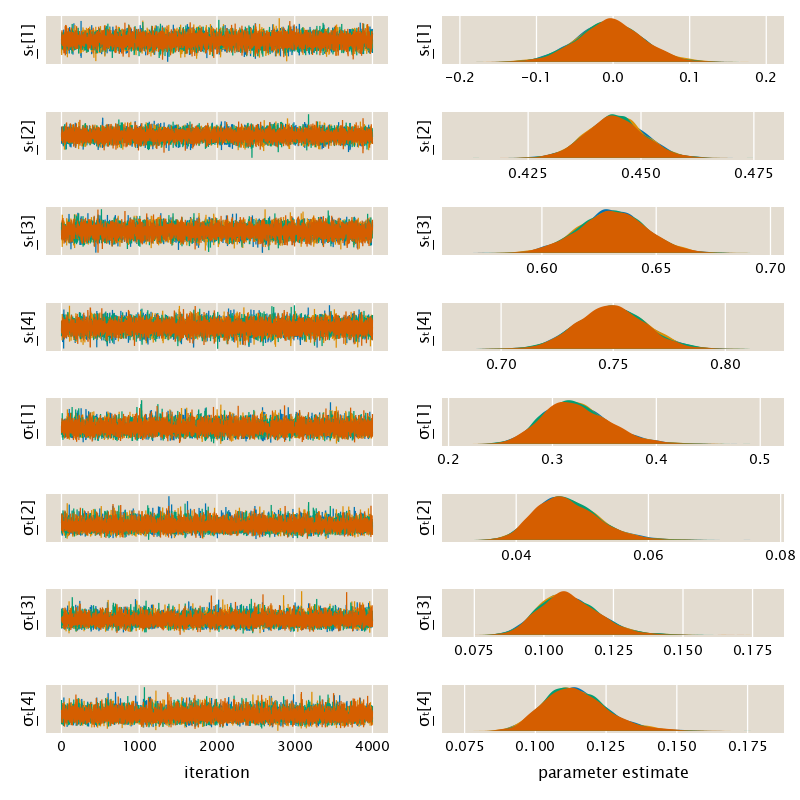

In [13]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

These traces look good, and the estimates of the mean fitness also gave
reasonable values.

# Bayesian model with frequency inference uncertainty

The naive model we presented above assumes that we perfectly measured the
frequency ratios $\gamma^{(n)}_t = f^{(n)}_{t+1} / f^{(n)}_{t}$. In reality, we
do not even measure the frequencies directly, but we measure the number of reads
for each barcode, $r^{(m)}_t$, and from that compute the frequencies. To be more
specific, let us define all reads for a particular time point as
$$
\underline{r}_t = \begin{bmatrix}
    \underline{r}^{(n)}_t \\
    \underline{r}^{(m)}_t \\
    \end{bmatrix},
\tag{18}
$$
where we further subdivide the reads into neutral lineages reads
$\underline{r}^{(n)}_t$ and mutant lineages reads $\underline{r}^{(m)}_t$. This
means that when inferring the mean fitness for a single pair of time points $t$
and $t+1$, we must marginalize over all possible frequency values. This is
$$
\pi(\bar{s}_t \mid \underline{r}_t, \underline{r}_{t+1}) = 
\int df_t^B \int df_t^B \;
\pi(
    \bar{s}_t, \underline{f}_t, \underline{f}_{t+1} \mid 
    \underline{r}_t, \underline{r}_{t+1}
),
\tag{19}
$$
where $B = N + M$ is the total number of unique barcodes given by the sum of
unique neutral and mutant barcodes. This means that the posterior we need to
sample from using MCMC is of the form
$$
\pi(
    \bar{s}_t, \underline{f}_t, \underline{f}_{t+1} \mid 
    \underline{r}_t, \underline{r}_{t+1}
) \propto
\pi(
    \underline{r}_t, \underline{r}_{t+1} \mid
    \bar{s}_t, \underline{f}_t, \underline{f}_{t+1} 
)
\pi(\bar{s}_t, \underline{f}_t, \underline{f}_{t+1}).
\tag{20}
$$

As written, it is not clear how to define the terms in Eq. 20. Our fitness model
in Eq. 1 relates frequencies, not number of reads, to the mean fitness. Instead,
we can write the joint posterior distribution as a product of conditional
distributions of the form
$$
\pi(
    \bar{s}_t, \underline{f}_t, \underline{f}_{t+1} \mid 
    \underline{r}_t, \underline{r}_{t+1}
) = 
\pi(
    \bar{s}_t \mid \underline{f}_t, \underline{f}_{t+1},
    \underline{r}_t, \underline{r}_{t+1}
)
\pi(
    \underline{f}_t, \underline{f}_{t+1} \mid 
    \underline{r}_t, \underline{r}_{t+1}
).
\tag{21}
$$
Furthermore, again, since our fitness model connects fitness values to the mean
fitness, we can remove the conditioning on the number of reads for the first
term on the right-hand side of Eq. 21, obtaining.
$$
\pi(
    \bar{s}_t \mid \underline{f}_t, \underline{f}_{t+1},
    \underline{r}_t, \underline{r}_{t+1}
) = 
\pi(\bar{s}_t \mid \underline{f}_t, \underline{f}_{t+1}).
\tag{22}
$$
We can take this one step further by noticing that our inference of the mean
fitness only depends on the *neutral* lineages. Thus, we can rewrite Eq. 22 as
$$
\pi(\bar{s}_t \mid \underline{f}_t, \underline{f}_{t+1}) = 
\pi\left(\bar{s}_t \mid \underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1}\right).
\tag{23}
$$
Moreover, we make the safe assumption that the measured frequencies for each
time point are independent of each other, allowing us to rewrite the second term
on the right-hand side of Eq. 21 as
$$
\pi(
    \underline{f}_t, \underline{f}_{t+1} \mid 
    \underline{r}_t, \underline{r}_{t+1}
) = 
\pi(\underline{f}_t \mid \underline{r}_t)
\pi(\underline{f}_{t+1} \mid \underline{r}_{t+1}).
\tag{24}
$$
Notice that here we still keep both the neutral and the mutant frequencies. This
is because the value of all frequencies is correlated since an increment in any
frequency must come at a decrement of another frequency value to keep the
normalization constraint.

Let's dissect each of the terms.

### $\pi\left(\bar{s}_t \mid \underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1}\right)$

Notice that the term $\pi(\bar{s}_t \mid \underline{f}^{(n)}_t,
\underline{f}^{(n)}_{t+1})$ is not exactly what we worked out in our previous
model. Here, the input data are the frequencies by themselves rather than their
ratio. We will have to  beat this equation into that form. To do so, first we
write Bayes theorem
$$
\pi\left(\bar{s}_t \mid \underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1}\right) 
\propto 
\pi\left(\underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1} \mid \bar{s}_t\right)
\pi(\bar{s}_t).
\tag{25}
$$
As done in our previous model, we assume each barcode is independent of each
other. Their co-dependencies will be captured in the other term when inferring
frequencies from reads. This allows us to rewrite the first term on the 
right-hand side of Eq. 25 as
$$
\pi\left(\underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1} \mid \bar{s}_t\right) 
= \prod_{n=1}^N \pi\left(f^{(n)}_t, f^{(n)}_{t+1} \mid \bar{s}_t\right).
\tag{26}
$$

Using our definition for the frequency ratio in Eq. 7, we can define the 
frequency at time $t+1$ as
$$
f_{t+1} \equiv \gamma_t f_t.
\tag{27}
$$
This means that writing the joint distribution between the pair of frequencies
is equivalent to the joint distribution of one of the frequencies and the ratio,
i.e.,
$$
\pi\left(f^{(n)}_t, f^{(n)}_{t+1} \mid \bar{s}_t\right) =
\pi\left(f^{(n)}_t, \gamma^{(n)}_t \mid \bar{s}_t\right).
\tag{28}
$$
More conveniently, we can write the joint distribution in Eq. 28 as a product of
conditionals of the form
$$
\pi\left(f^{(n)}_t, \gamma^{(n)}_t \mid \bar{s}_t\right) =
\pi\left(f^{(n)}_t \mid \gamma^{(n)}_t, \bar{s}_t\right)
\pi\left(\gamma^{(n)}_t \mid \bar{s}_t\right).
\tag{29}
$$

As in our previous naive model, we can assume that the frequency ratios follow a
log normal distribution, i.e., the second term on the right-hand side of Eq. 29
is of the form
$$
\gamma_t^{(n)} \mid \bar{s}_t, \sigma_t \sim 
\log\mathcal{N}(-\bar{s}_t, \sigma_t),
\tag{30}
$$
where we again added the nuisance parameter $\sigma_t$. For the first term on
the right-hand side of Eq. 29, we can remove the conditioning on the mean 
fitness since it does not add further information to the value of $f_t^{(n)}$ 
that $\gamma_t^{(n)}$ doesn't contain already. Thus, we have
$$
\pi\left(f^{(n)}_t \mid \gamma^{(n)}_t, \bar{s}_t\right) =
\pi\left(f^{(n)}_t \mid \gamma^{(n)}_t\right).
\tag{31}
$$
Furthermore, given that we know the value of the frequency ratio, we know that
the numerator $f_{t+1}^{(n)}$ can only take values between 0 and 1. Therefore, 
the denominator can only take values between 0 and $1 / \gamma_t^{(n)}$. This
means Eq. 31 is of the form
$$
f^{(n)}_t \mid \gamma^{(n)}_t \sim 
\text{Uniform}\left(0, \frac{1}{\gamma_t^{(n)}}\right).
\tag{32}
$$

The inference in Eq. 25 then takes the form
$$
\pi\left(
    \bar{s}_t, \sigma_t \mid 
    \underline{f}^{(n)}_t, \underline{f}^{(n)}_{t+1}
\right) \propto
\pi\left(f^{(n)}_t \mid \gamma^{(n)}_t\right)
\pi\left(\gamma^{(n)}_t \mid \bar{s}_t, \sigma_t \right)
\pi(\bar{s}_t) \pi(\sigma_t),
\tag{33}
$$
where we use the same weakly informative priors for our parameters as in our
previous model.

So far our inference assumed that we measured barcode frequencies with infinite
precision. In reality, we measure noisy read counts and from that we must
estimate the relative frequency of each of the barcodes. For this part of the
inference, we 

In [232]:
Turing.@model function mean_fitness_neutrals_full(
    r̲ₜ, r̲ₜ₊₁, α̲, σₛ, σₑ
)
    # Prior on mean fitness sₜ
    sₜ ~ Turing.Normal(0.0, σₛ)
    # Prior on LogNormal error σₜ
    σₜ ~ Turing.truncated(Turing.Normal(0.0, σₑ); lower=0.0)

    # Frequency distribution from Multinomial-Dirichlet model
    f̲ₜ ~ Turing.Dirichlet(α̲ .+ r̲ₜ)
    f̲ₜ₊₁ ~ Turing.Dirichlet(α̲ .+ r̲ₜ₊₁)

    # Check that all distributions are greater than zero. Although the counts
    # could be zero, we assume that the real frequencies are non-zero always.
    if any(iszero.(f̲ₜ)) | any(iszero.(f̲ₜ₊₁))
        Turing.@addlogprob! -Inf
        return 
    end

    # Compute frequency ratio
    γₜ = (f̲ₜ₊₁ ./ f̲ₜ)[1:end-1]

    # Sample posterior for frequency ratio. NOTE: This took me an incredibly
    # long time to figure out. Since the quantity γₜ is not given as input
    # observations to the model, Turing does not add the evaluation of the log
    # likelihood to the overall posterior. This ends up having sₜ sampled
    # directly from the prior. To force Turing to consider γₜ as an "observed"
    # variable, we must force the addition of the log density using the
    # @addlogprob! macro.
    Turing.@addlogprob! Turing.logpdf(
        Turing.MvLogNormal(
            FillArrays.Fill(-sₜ, length(γₜ)), 
            LinearAlgebra.I(length(γₜ)) .* σₜ^2
        ),
        γₜ
    )
    
end # @model function

mean_fitness_neutrals_full (generic function with 4 methods)

In [208]:
Random.seed!(42)

# Define information for data to extract
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Define time points
t1 = "T3"
t2 = "T4"
# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep) .&
        ((df.timepoint .== t1) .| (df.timepoint .== t2))
    ,
:]

# Group data by neutral barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)

# Initialize array to save counts
r = Matrix{Int64}(undef, length(data_group) + 1, 2)
# Initialize array to save frequencies
f = Matrix{Float64}(undef, length(data_group) + 1, 2)

# Loop through barcodes
for (i, group) in enumerate(data_group)
    # Sort data by timepoint
    DF.sort!(group, :timepoint)
    r[i, :] = group.count
end # for

# Add mutant counts
r[end, 1] = sum(data[.!(data.neutral) .& (data.timepoint .== t1), :count])
r[end, 2] = sum(data[.!(data.neutral) .& (data.timepoint .== t2), :count])

# Set α values for Dirichlet distribution
α = ones(size(r, 1))
# Modify last α value for all mutant phenotypes
α[end] = sum(.!(data.neutral) .& (data.timepoint .== t1))

4971

In [234]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals_full(r[:, 1], r[:, 2], α, 5.0, 1.0)

# Sample
# # Suppress warning outputs
# Suppressor.@suppress begin
#     # Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(1000, 0.65), 
    Turing.MCMCThreads(), 
    1000, 
    4, 
    progress=false
)
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          sₜ    0.7532    0.0138    0.0002   4126.4117   3635.2623    1.0030   ⋯
          σₜ    0.0990    0.0106    0.0002   3616.6806   3277.7418    1.0004   ⋯
       f̲ₜ[1]    0.0014    0.0000    0.0000   4081.2903   2776.2897    1.0024   ⋯
       f̲ₜ[2]    0.0018    0.0000    0.0000   3850.9959   2712.3209    1.0014   ⋯
       f̲ₜ[3]    0.0020    0.0000    0.0000   4214.2155   2473.6980    1.0028   ⋯
       f̲ₜ[4]    0.0018    0.0000    0.0000   3772.7234   2470.6204    1.0010   ⋯
       f̲ₜ[5]    0.0010    0.0000    0.0000   4024.0174   2875.2390    1.0014   ⋯
       f̲ₜ[6]    0.0021    0.0000    0.0000   4044.3102   2726.6349    1.0005   ⋯
       f̲ₜ[7]    0.0008    0.0000    0.0000   3904.9951   2993.3378    1.0004   ⋯
       f̲ₜ[8]    0.0013    0.0000    0.0000   3846.1811   2671.7730    1.0008   ⋯


the diagnostics look pretty good. Let's take a look at the traces for the
population mean fitness and the error.

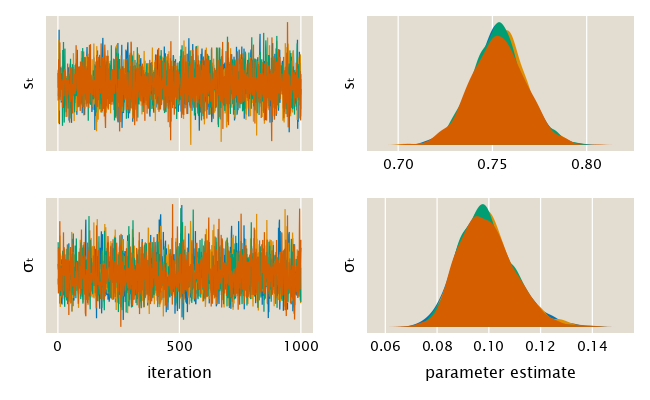

In [237]:
# Initialize figure
fig = Figure(resolution=(650, 400))

BayesFitness.viz.mcmc_trace_density!(fig, chain[:, [:sₜ, :σₜ], :])

fig


The traces look really good. Furthermore, the $\bar{s}_t$ density looks quite
symmetric. We can summarize the distribution by fitting a Gaussian to the
samples.

In [238]:
Distributions.fit(Distributions.Normal{Float64}, vec(Matrix(chain[:, :sₜ, :])))

Distributions.Normal{Float64}(μ=0.7532271331371136, σ=0.013846293841680332)